## Miniproject 2: MovieLens Visualization



### Download data

In [2]:
import requests

url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (1-reg*eta)*Ui + eta * Vj * (Yij - np.dot(Ui,Vj))     

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (1-reg*eta)*Vj + eta * Ui * (Yij - np.dot(Ui,Vj))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # Compute mean squared error on each data point in Y; include
    # regularization penalty in error calculations.
    # We first compute the total squared squared error
    err = 0.0
    for (i,j,Yij) in Y:
        err += 0.5 *(Yij - np.dot(U[i-1], V[:,j-1]))**2
    # Add error penalty due to regularization if regularization
    # parameter is nonzero
    if reg != 0:
        U_frobenius_norm = np.linalg.norm(U, ord='fro')
        V_frobenius_norm = np.linalg.norm(V, ord='fro')
        err += 0.5 * reg * (U_frobenius_norm ** 2)
        err += 0.5 * reg * (V_frobenius_norm ** 2)
    # Return the mean of the regularized error
    return err / float(len(Y))

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # Initialize U, V  
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((K,N)) - 0.5
    size = Y.shape[0]
    delta = None
    indices = np.arange(size)    
    for epoch in range(max_epochs):
        # Run an epoch of SGD
        before_E_in = get_err(U, V, Y, reg)
        np.random.shuffle(indices)
        for ind in indices:
            (i,j, Yij) = Y[ind]
            # Update U[i], V[j]
            U[i-1] = grad_U(U[i-1], Yij, V[:,j-1], reg, eta)
            V[:,j-1] = grad_V(V[:,j-1], Yij, U[i-1], reg, eta);
        # At end of epoch, print E_in
        E_in = get_err(U, V, Y, reg)
        print("Epoch %s, E_in (regularized MSE): %s"%(epoch + 1, E_in))

        # Compute change in E_in for first epoch
        if epoch == 0:
            delta = before_E_in - E_in

        # If E_in doesn't decrease by some fraction <eps>
        # of the initial decrease in E_in, stop early            
        elif before_E_in - E_in < eps * delta:
            break
    return (U, V, get_err(U, V, Y))

In [5]:
M = max(data["User ID"]) # number of users
N = max(data["Movie ID"]) # number of movies

K = 20

reg = 0.1
eta = 0.03 # learning rate

U,V,err = train_model(M, N, K, eta, reg, train.to_numpy())
test_err = get_err(U, V, test.to_numpy())
print("Test error " + str(test_err))

Epoch 1, E_in (regularized MSE): 0.5070592783735204
Epoch 2, E_in (regularized MSE): 0.4363538113692233
Epoch 3, E_in (regularized MSE): 0.40832638315172565
Epoch 4, E_in (regularized MSE): 0.3880690421903028
Epoch 5, E_in (regularized MSE): 0.3748750861374199
Epoch 6, E_in (regularized MSE): 0.3705174676831105
Epoch 7, E_in (regularized MSE): 0.35437641654741286
Epoch 8, E_in (regularized MSE): 0.3490925376880315
Epoch 9, E_in (regularized MSE): 0.34481849710232626
Epoch 10, E_in (regularized MSE): 0.3317260346793346
Epoch 11, E_in (regularized MSE): 0.3298313469443828
Epoch 12, E_in (regularized MSE): 0.32365824068034676
Epoch 13, E_in (regularized MSE): 0.32146349977306565
Epoch 14, E_in (regularized MSE): 0.3182563529940807
Epoch 15, E_in (regularized MSE): 0.314600558423622
Epoch 16, E_in (regularized MSE): 0.3094967828331871
Epoch 17, E_in (regularized MSE): 0.3097403355727747
Test error 0.44589478322051057


In [6]:
A, _, _ = np.linalg.svd(V)
A1 = (A[:,:2]).T
print(A1.shape)
print(U.shape)
print(V.shape)
Ut = np.matmul(A1, U.T)
Vt = np.matmul(A1, V)
print(Vt.shape)

(2, 20)
(943, 20)
(20, 1682)
(2, 1682)


In [22]:
most_popular = data['Movie ID'].value_counts()[:10].index.to_numpy()
most_popular_labels = movies.loc[movies['Movie ID'].isin(most_popular)]["Movie Title"]
print(most_popular)
print(most_popular_labels)
most_popular_labels = most_popular_labels[most_popular - 1].to_numpy()
most_popular_labels

[ 50 258 100 181 294 286 288   1 300 121]
0                   Toy Story (1995)
49                  Star Wars (1977)
99                      Fargo (1996)
120    Independence Day (ID4) (1996)
180        Return of the Jedi (1983)
257                   Contact (1997)
285      English Patient, The (1996)
287                    Scream (1996)
293                 Liar Liar (1997)
299             Air Force One (1997)
Name: Movie Title, dtype: object


array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [23]:
condensed = data.groupby('Movie ID', as_index=False, sort=False)['Rating'].mean()
best = np.asarray(condensed.nlargest(10, 'Rating')["Movie ID"].tolist())
best_labels = movies.loc[movies['Movie ID'].isin(best)]["Movie Title"]
print(best)
best_labels = best_labels[best - 1].to_numpy()
print(best_labels)

[1189 1500  814 1536 1293 1599 1653 1467 1122 1201]
['Prefontaine (1997)' 'Santa with Muscles (1996)'
 'Great Day in Harlem, A (1994)' 'Aiqing wansui (1994)' 'Star Kid (1997)'
 "Someone Else's America (1995)"
 'Entertaining Angels: The Dorothy Day Story (1996)'
 'Saint of Fort Washington, The (1993)' 'They Made Me a Criminal (1939)'
 'Marlene Dietrich: Shadow and Light (1996) ']


          x         y                           name
0 -2.454857 -0.084593               Star Wars (1977)
1 -2.008235 -0.104699                 Contact (1997)
2 -2.160644  0.643385                   Fargo (1996)
3 -2.100653 -0.346468      Return of the Jedi (1983)
4 -1.741654 -0.708726               Liar Liar (1997)
5 -1.799533  0.240880    English Patient, The (1996)
6 -1.676437 -0.343355                  Scream (1996)
7 -2.112473 -0.236492               Toy Story (1995)
8 -1.766730 -0.766803           Air Force One (1997)
9 -1.788783 -0.924739  Independence Day (ID4) (1996)


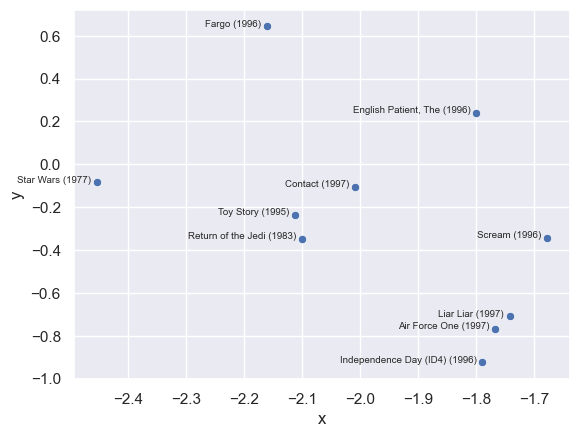

In [24]:
most_popular_data = pd.DataFrame(Vt[:,most_popular-1].T, columns=['x', 'y'])
most_popular_data.insert(2, 'name', most_popular_labels, True)
print(most_popular_data)
sns.scatterplot(data=most_popular_data, x='x', y='y')

for i in range(len(most_popular_data)):
    plt.text(most_popular_data['x'][i] - 0.01, most_popular_data['y'][i], \
             most_popular_data['name'][i], fontsize=7, ha='right')

          x         y                                               name
0 -2.261525 -0.096907                                 Prefontaine (1997)
1 -2.302993 -0.664028                          Santa with Muscles (1996)
2 -1.798361  0.515864                      Great Day in Harlem, A (1994)
3 -1.277958  0.972095                               Aiqing wansui (1994)
4 -1.848914  0.441995                                    Star Kid (1997)
5 -1.661800 -0.247768                      Someone Else's America (1995)
6 -1.431772 -0.799673  Entertaining Angels: The Dorothy Day Story (1996)
7 -2.176227  0.357246               Saint of Fort Washington, The (1993)
8 -2.097204  0.096104                     They Made Me a Criminal (1939)
9 -1.834805  0.197518         Marlene Dietrich: Shadow and Light (1996) 


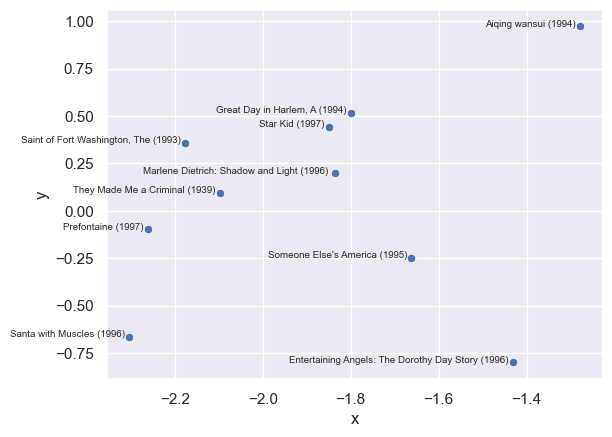

In [25]:
best_data = pd.DataFrame(Vt[:,best-1].T, columns=['x', 'y'])
best_data.insert(2, 'name', best_labels, True)
print(best_data)
sns.scatterplot(data=best_data, x='x', y='y')

for i in range(len(best_data)):
    plt.text(best_data['x'][i] - 0.01, best_data['y'][i], \
             best_data['name'][i], fontsize=7, ha='right')

           x         y                                               name
0  -2.112473 -0.236492                                   Toy Story (1995)
1  -1.588961 -0.480042                                   GoldenEye (1995)
2  -1.764723 -0.131020                                  Four Rooms (1995)
3  -1.904052  0.160463                                  Get Shorty (1995)
4  -1.717357 -0.692580                                     Copycat (1995)
5  -1.824930  0.321637  Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6  -2.105554  0.223497                              Twelve Monkeys (1995)
7  -2.301540  0.107332                                        Babe (1995)
8  -2.306030  0.493274                            Dead Man Walking (1995)
9  -1.984328  0.458352                                 Richard III (1995)
10 -2.005933 -0.125523                               Seven (Se7en) (1995)
11 -2.376486  0.190763                         Usual Suspects, The (1995)
12 -1.822646  0.490214                

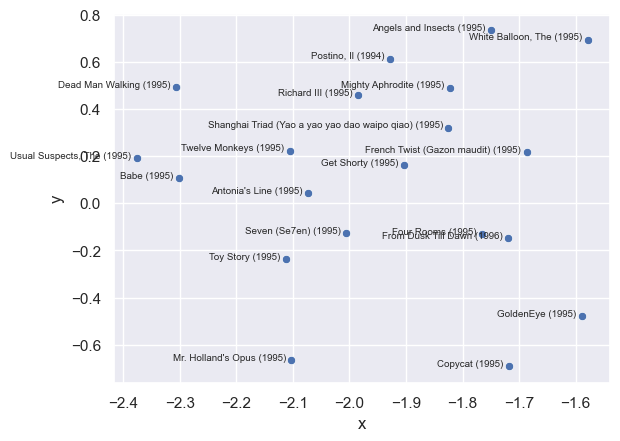

In [29]:
movie_id1 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
labels1 = movies.loc[movies['Movie ID'].isin(movie_id1)]["Movie Title"]
labels1 = labels1[movie_id1 - 1].to_numpy()

selected_data = pd.DataFrame(Vt[:,movie_id1-1].T, columns=['x', 'y'])
selected_data.insert(2, 'name', labels1, True)
print(selected_data)
sns.scatterplot(data=selected_data, x='x', y='y')

for i in range(len(selected_data)):
    plt.text(selected_data['x'][i] - 0.01, selected_data['y'][i], \
             selected_data['name'][i], fontsize=7, ha='right')